<h2><br>WDB Systems India Pvt Ltd</br>
<br>Member 1:- KOSURI PRAHARSHA</br>
<br>Member 2:- KOSURI VENU MADHAVA RAO </br>
<br>SPECTRA PURE –MODEL</br>


<h2> Import Libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

<h2>Configuration </h2>

In [2]:
input_file="heart_data.csv"
split_percentage=0.3

#Model Tuning Paramaeters
alpha = 0.005
epochs = 150000
batch_size= 16

In [3]:
hrt_df = pd.read_csv(input_file)
hrt_df.head(0)
hrt_df.shape 

# Drop duplicates
hrt_df.drop_duplicates(inplace=True)

# Remove outliers using IQR (only for continuous features)
col_num = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in col_num:
    Q1 = hrt_df[col].quantile(0.25)
    Q3 = hrt_df[col].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR
    hrt_df = hrt_df[(hrt_df[col] >= LowerBound) & (hrt_df[col] <= UpperBound)]

hrt_df = hrt_df.reset_index(drop=True)


<h2>Extract input (X) and output (Y)</h2>

In [4]:

# Split features and target
X = hrt_df.drop(columns=['target']).values
print('i am here')
print(X[0]);
Y = hrt_df['target'].values.reshape(-1, 1) 
print(f"✅ Data Shape: {X.shape}")

i am here
[ 63.    1.    3.  145.  233.    1.    0.  150.    0.    2.3   0.    0.
   1. ]
✅ Data Shape: (283, 13)


<h2>Splitting training and test data</h2>

In [5]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_percentage, random_state=20)
print(f"✅ Data Ready. Train: {X_train.shape}, Test: {X_test.shape}")
'''
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)
'''
scaler = MinMaxScaler()#It is normalisation of features.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

✅ Data Ready. Train: (198, 13), Test: (85, 13)


<h2>Helper Functions</h2>

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred):
    m = len(y)
    epsilon = 1e-8
    return -(1/m) * np.sum(y*np.log(y_pred + epsilon) + (1-y)*np.log(1 - y_pred + epsilon))

def f1_score_func(y_true, y_pred, threshold=0.5):
    y_pred_class = (y_pred >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred_class == 1))
    fp = np.sum((y_true == 0) & (y_pred_class == 1))
    fn = np.sum((y_true == 1) & (y_pred_class == 0))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

def plot_loss(loss_history, title):
    plt.figure(figsize=(7,5))
    plt.plot(loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()
    
def evaluate_model(weights, bias, X_test, Y_test, title):
    y_pred_probs = sigmoid(np.dot(X_test, weights) + bias)
    y_pred_class = (y_pred_probs >= 0.5).astype(int)

    accuracy = accuracy_score(Y_test, y_pred_class)
    report = classification_report(Y_test, y_pred_class, output_dict=True, zero_division=0)
    conf_mat = confusion_matrix(Y_test, y_pred_class)
    f1 = f1_score_func(Y_test, y_pred_probs)

    tn, fp, fn, tp = conf_mat.ravel()
    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)

    print(f"\n📊 {title} Results:")
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_mat)

    return {
        "Method": title,
        "Accuracy": accuracy,
        "F1-Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }
        

<h2>Vanilla/Full Batch Gradient Descent</h2>

In [7]:
def batch_gradient_descent(X, Y, alpha, epochs):
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, 1))
    bias = 0
    loss_history = []

    for i in range(epochs):
        z = np.dot(X, weights) + bias
        y_pred = sigmoid(z)

        dw = (1/n_samples) * np.dot(X.T, (y_pred - Y))
        db = (1/n_samples) * np.sum(y_pred - Y)

        weights -= alpha * dw
        bias -= alpha * db

        loss = compute_loss(Y, y_pred)
        loss_history.append(loss)

    print("\n🔹 Final Weights (Batch GD):", weights.ravel())
    print("🔹 Final Bias (Batch GD):", bias)

    return weights, bias, loss_history

<h2>Stoichastic Gradient Descent</h2>

In [8]:
def stochastic_gradient_descent(X, Y, alpha, epochs):
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, 1))
    bias = 0
    loss_history = []

    for epoch in range(epochs):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        for i in indices:
            x_i = X[i].reshape(1, -1)
            y_i = Y[i]

            z = np.dot(x_i, weights) + bias
            y_pred = sigmoid(z)

            dw = np.dot(x_i.T, (y_pred - y_i))
            db = (y_pred - y_i)

            weights -= alpha * dw
            bias -= alpha * db

        y_pred_all = sigmoid(np.dot(X, weights) + bias)
        loss = compute_loss(Y, y_pred_all)
        loss_history.append(loss)

    print("\n🔹 Final Weights (Stochastic GD):", weights.ravel())
    print("🔹 Final Bias (Stochastic GD):", bias)

    return weights, bias, loss_history


<h2>Minibatch Gradient Descent</h2>

In [9]:
def mini_batch_gradient_descent(X, Y, alpha, epochs, batch_size):
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, 1))
    bias = 0
    loss_history = []

    for epoch in range(epochs):
        indices = np.arange(n_samples)
        #print("indices: ",indices)
        np.random.shuffle(indices)
        X_s = X[indices]
        Y_s = Y[indices]

        for start in range(0, n_samples, batch_size):
            end = start + batch_size
            x_batch = X_s[start:end]
            y_batch = Y_s[start:end]

            z = np.dot(x_batch, weights) + bias
            y_pred = sigmoid(z)

            dw = (1 / len(x_batch)) * np.dot(x_batch.T, (y_pred - y_batch))
            db = (1 / len(x_batch)) * np.sum(y_pred - y_batch)

            weights -= alpha * dw
            bias -= alpha * db

        y_pred_all = sigmoid(np.dot(X, weights) + bias)
        loss = compute_loss(Y, y_pred_all)
        loss_history.append(loss)

    print("\n🔹 Final Weights (Mini-Batch GD):", weights.ravel())
    print("🔹 Final Bias (Mini-Batch GD):", bias)

    return weights, bias, loss_history


<h2>Vanilla2 Gradient Descent</h2>

In [10]:
# --------------------------
# 5️⃣+ Vanilla Logistic Regression (using scipy.optimize)
# --------------------------

def vanilla2(X, Y):
    import scipy.optimize as op

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def costFunction(theta, X, y):
        m, n = X.shape
        theta = theta.reshape((n, 1))
        z = np.dot(X, theta)
        h = sigmoid(z)
        epsilon = 1e-8
        cost = -(1/m) * np.sum(y*np.log(h+epsilon) + (1-y)*np.log(1-h+epsilon))
        grad = (1/m) * np.dot(X.T, (h - y))
        return cost, grad.flatten()

    # Add bias column (intercept term)
    X_bias = np.hstack((np.ones((X.shape[0], 1)), X))
    m, n = X_bias.shape
    initial_theta = np.zeros((n, 1))

    # Optimize using scipy fmin_tnc
    result = op.fmin_tnc(func=costFunction, x0=initial_theta, args=(X_bias, Y))
    theta_opt = result[0].reshape((n, 1))

    weights = theta_opt[1:]
    bias = theta_opt[0]

    print("\n🔹 Final Weights (Vanilla2):", weights.ravel())
    print("🔹 Final Bias (Vanilla2):", bias)

    return weights, bias


<h2>Training and Evaluating Models</h2>


🔹 Final Weights (Batch GD): [-0.47980221 -1.51110489  2.03456192 -1.02443515 -1.29310406  0.18836858
  0.84919559  2.59788944 -0.77029334 -1.87927884  1.43449734 -3.39647256
 -2.19104427]
🔹 Final Bias (Batch GD): 2.256978843237826


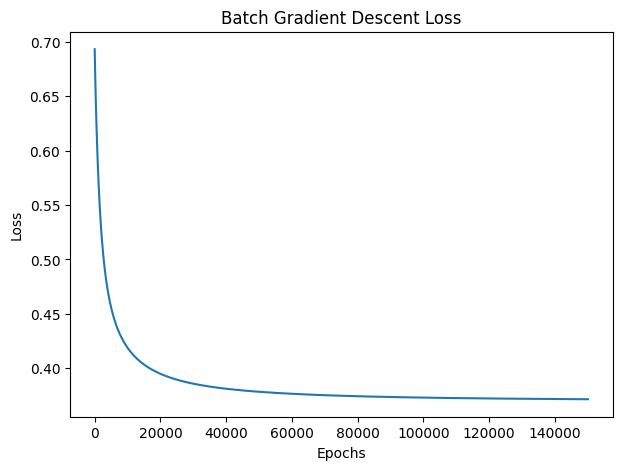


📊 Batch Gradient Descent Results:
Accuracy: 0.8823529411764706
F1-Score: 0.8999999948280001
Sensitivity (Recall): 0.9374999998046875
Specificity: 0.8108108105916727
Confusion Matrix:
 [[30  7]
 [ 3 45]]


In [11]:
results = []

# Batch
w_b, b_b, loss_b = batch_gradient_descent(X_train, Y_train,alpha,epochs)
plot_loss(loss_b, "Batch Gradient Descent Loss")
results.append(evaluate_model(w_b, b_b, X_test, Y_test, "Batch Gradient Descent"))



🔹 Final Weights (Stochastic GD): [-0.66515452 -1.589198    2.02430257 -1.15333115 -1.71826293  0.1763596
  0.81075527  2.51990392 -0.81616767 -2.09015695  1.30096882 -3.49226801
 -2.60965699]
🔹 Final Bias (Stochastic GD): [[3.22608448]]


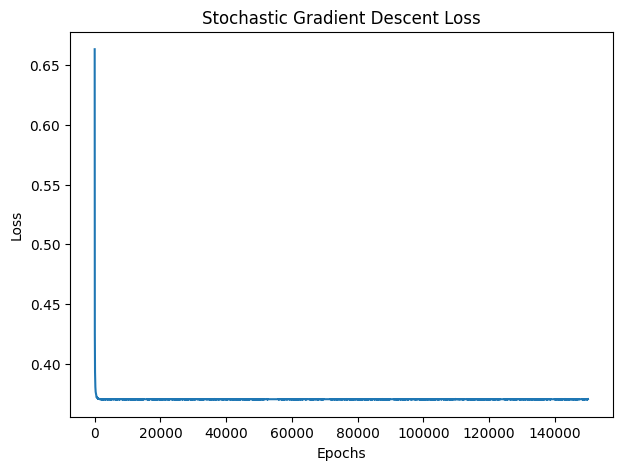


📊 Stochastic Gradient Descent Results:
Accuracy: 0.8705882352941177
F1-Score: 0.8888888837139067
Sensitivity (Recall): 0.9166666664756944
Specificity: 0.8108108105916727
Confusion Matrix:
 [[30  7]
 [ 4 44]]


In [12]:
# Stochastic
w_s, b_s, loss_s = stochastic_gradient_descent(X_train, Y_train,alpha,epochs)
plot_loss(loss_s, "Stochastic Gradient Descent Loss")
results.append(evaluate_model(w_s, b_s, X_test, Y_test, "Stochastic Gradient Descent"))




🔹 Final Weights (Mini-Batch GD): [-0.66389423 -1.58336193  2.02970151 -1.14617385 -1.71182119  0.17605343
  0.81059092  2.52399821 -0.81615906 -2.07957462  1.30332273 -3.49623145
 -2.60896983]
🔹 Final Bias (Mini-Batch GD): 3.2312270860316423


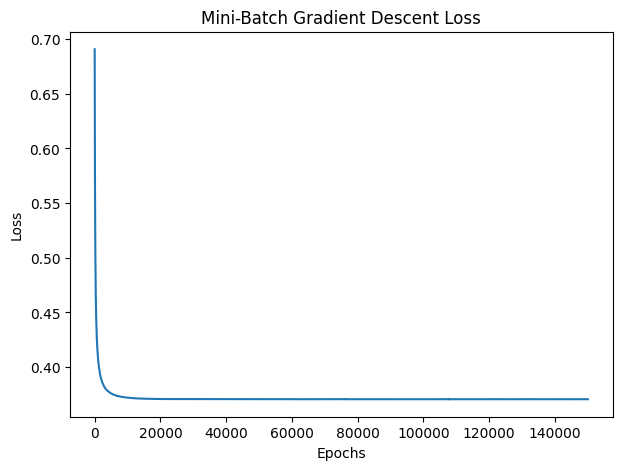


📊 Mini-Batch Gradient Descent Results:
Accuracy: 0.8705882352941177
F1-Score: 0.8888888837139067
Sensitivity (Recall): 0.9166666664756944
Specificity: 0.8108108105916727
Confusion Matrix:
 [[30  7]
 [ 4 44]]


In [13]:
# Mini-Batch
w_m, b_m, loss_m = mini_batch_gradient_descent(X_train, Y_train,alpha,epochs,batch_size)
plot_loss(loss_m, "Mini-Batch Gradient Descent Loss")
results.append(evaluate_model(w_m, b_m, X_test, Y_test, "Mini-Batch Gradient Descent"))



In [14]:
# Vanilla2 (using scipy.optimize)
w_v2, b_v2 = vanilla2(X_train, Y_train)
results.append(evaluate_model(w_v2, b_v2, X_test, Y_test, "Vanilla2 Logistic Regression"))


🔹 Final Weights (Vanilla2): [-0.66395745 -1.58584837  2.02617988 -1.15042436 -1.71475084  0.17670155
  0.81239104  2.52228809 -0.81447338 -2.08735646  1.30360175 -3.48881132
 -2.60273578]
🔹 Final Bias (Vanilla2): [3.23077763]

📊 Vanilla2 Logistic Regression Results:
Accuracy: 0.8705882352941177
F1-Score: 0.8888888837139067
Sensitivity (Recall): 0.9166666664756944
Specificity: 0.8108108105916727
Confusion Matrix:
 [[30  7]
 [ 4 44]]


<h2>Summary Table</h2>

In [15]:
summary_df = pd.DataFrame(results)
print("\n✅ Final Performance Summary:")
print(summary_df)


✅ Final Performance Summary:
                         Method  Accuracy  F1-Score  Sensitivity  Specificity
0        Batch Gradient Descent  0.882353  0.900000     0.937500     0.810811
1   Stochastic Gradient Descent  0.870588  0.888889     0.916667     0.810811
2   Mini-Batch Gradient Descent  0.870588  0.888889     0.916667     0.810811
3  Vanilla2 Logistic Regression  0.870588  0.888889     0.916667     0.810811
